In [1]:
import pandas as pd
import numpy as np
from nfl_data_py import import_weekly_data, import_players, import_rosters
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# 1. Fetch data
seasons = range(2018, 2024)  # Adjust the range as needed
player_stats = pd.concat([import_weekly_data([season]) for season in seasons])
players = import_players()
latest_rosters = import_rosters([2024])  # For 2024 predictions

# 2. Preprocess data
df = pd.merge(player_stats, players, left_on='player_id', right_on='gsis_id', how='left')
df = df.sort_values(['player_id', 'season', 'week'])

# Create target variables
df['next_week_passing_yards'] = df.groupby(['player_id', 'season'])['passing_yards'].shift(-1)
df['next_week_rushing_yards'] = df.groupby(['player_id', 'season'])['rushing_yards'].shift(-1)
df['next_week_receiving_yards'] = df.groupby(['player_id', 'season'])['receiving_yards'].shift(-1)

# Remove last week of each season for each player
df = df.groupby(['player_id', 'season']).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

# Identify features
categorical_features = ['position_x', 'recent_team']
numerical_features = ['passing_yards', 'rushing_yards', 'receiving_yards']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features)
    ])

# Prepare features
X = df[categorical_features + numerical_features]

# Fit preprocessor and transform data
X_transformed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
feature_names = (numerical_features + 
                 preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())

# 3. Build and train models
input_dim = X_transformed.shape[1]

def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train models for each stat
models = {}
for stat in ['passing_yards', 'rushing_yards', 'receiving_yards']:
    y = df[f'next_week_{stat}'].values
    mask = ~np.isnan(y)
    X_stat = X_transformed[mask]
    y_stat = y[mask]
    
    models[stat] = create_model(input_dim)
    models[stat].fit(X_stat, y_stat, epochs=100, batch_size=32, validation_split=0.2, verbose=0)


2024-08-23 15:20:14.452958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 15:20:15.213238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.
Downcasting floats.


/tmp/ipykernel_66581/108750677.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['player_id', 'season']).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
/home/gin-g/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2024-08-23 15:20:24.294338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

In [2]:
def predict_2024_week1(player_name):
    try:
        # Find the player in the latest roster
        player_matches = latest_rosters[latest_rosters['player_name'].str.contains(player_name, case=False, na=False)]
        
        if player_matches.empty:
            print(f"Error: Player '{player_name}' not found in the latest roster.")
            return None
        
        if len(player_matches) > 1:
            print(f"Multiple matches found for '{player_name}'. Using the first match.")
        
        player_info = player_matches.iloc[0]
        
        # Get the player's stats from the last available week
        player_stats = df[(df['player_id'] == player_info['player_id']) & (df['season'] == 2023)]
        
        if player_stats.empty:
            print(f"Error: No 2023 stats found for '{player_name}'.")
            return None
        
        last_stats = player_stats.sort_values('week').iloc[-1]
        
        # Prepare input data
        input_data = pd.DataFrame({
            'position_x': [player_info['position']],
            'recent_team': [player_info['team']],
            'passing_yards': [last_stats['passing_yards']],
            'rushing_yards': [last_stats['rushing_yards']],
            'receiving_yards': [last_stats['receiving_yards']]
        })
        
        # Transform input data using the same preprocessor
        input_transformed = preprocessor.transform(input_data)
        
        # Make predictions
        predictions = {stat: models[stat].predict(input_transformed)[0][0] for stat in models}
        
        print(f"2024 Week 1 Prediction for {player_name}:")
        print(f"Team: {player_info['team']}")
        print(f"Position: {player_info['position']}")
        
        if player_info['position'] in ['QB']:
            print(f"Predicted passing yards: {predictions['passing_yards']:.2f}")
            print(f"Predicted rushing yards: {predictions['rushing_yards']:.2f}")
        elif player_info['position'] in ['RB']:
            print(f"Predicted rushing yards: {predictions['rushing_yards']:.2f}")
            print(f"Predicted receiving yards: {predictions['receiving_yards']:.2f}")
        elif player_info['position'] in ['WR', 'TE']:
            print(f"Predicted receiving yards: {predictions['receiving_yards']:.2f}")
        
        return predictions
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

# Example usage
predict_2024_week1("Patrick Mahomes")
predict_2024_week1("Christian McCaffrey")
predict_2024_week1("Travis Kelce")
predict_2024_week1("Justin Jefferson")

1/1 [==============================] - 0s 49ms/step
2024 Week 1 Prediction for Patrick Mahomes:
Team: KC
Position: QB
Predicted passing yards: 283.18
Predicted rushing yards: 19.41
1/1 [==============================] - 0s 20ms/step
2024 Week 1 Prediction for Christian McCaffrey:
Team: SF
Position: RB
Predicted rushing yards: 78.58
Predicted receiving yards: 26.82
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Travis Kelce:
Team: KC
Position: TE
Predicted receiving yards: 86.32
1/1 [==============================] - 0s 24ms/step
2024 Week 1 Prediction for Justin Jefferson:
Team: MIN
Position: WR
Predicted receiving yards: 42.85


{'passing_yards': 0.1725545,
 'rushing_yards': 1.5855873,
 'receiving_yards': 42.85188}

Error: No 2023 stats found for 'Aaron Rodgers'.
Error: No 2023 stats found for 'Max Duggan'.
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Jaren Hall:
Team: MIN
Position: QB
Predicted passing yards: 231.74
Predicted rushing yards: 11.96
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Dorian Thompson-Robinson:
Team: CLE
Position: QB
Predicted passing yards: 41.88
Predicted rushing yards: 4.68
1/1 [==============================] - 0s 20ms/step
2024 Week 1 Prediction for Clayton Tune:
Team: ARI
Position: QB
Predicted passing yards: 64.37
Predicted rushing yards: 4.38
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Aidan O'Connell:
Team: LV
Position: QB
Predicted passing yards: 255.41
Predicted rushing yards: 7.98
Error: No 2023 stats found for 'Hendon Hooker'.
1/1 [==============================] - 0s 23ms/step
2024 Week 1 Prediction for Tommy DeVito:
Team: NYG
Position: QB
Predicted passing ya

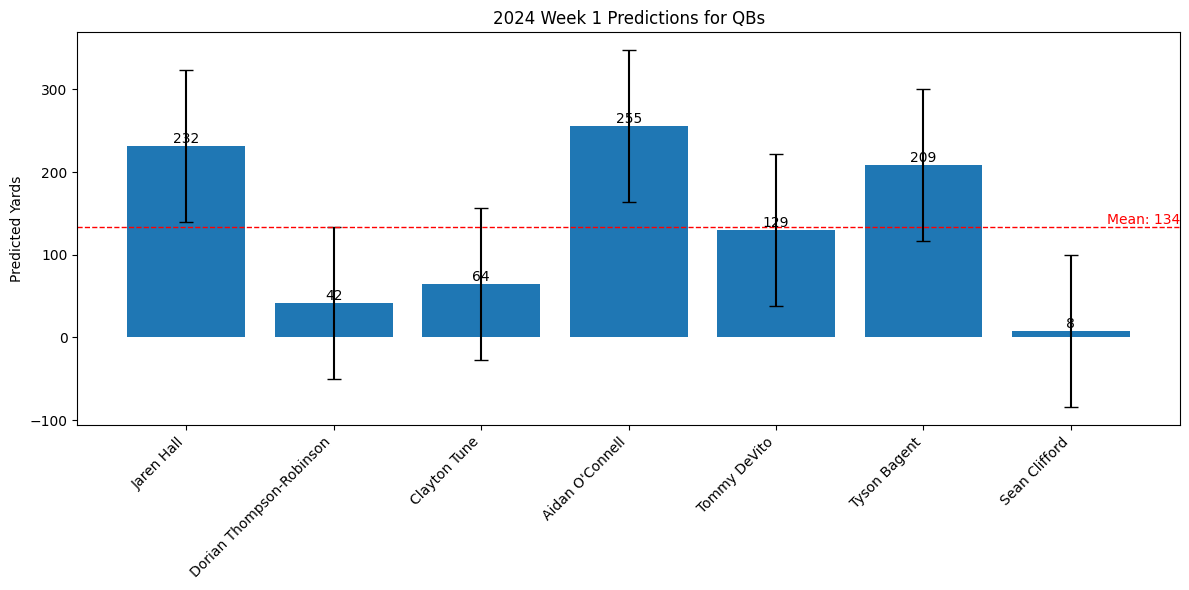

1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Kyle Juszczyk:
Team: SF
Position: RB
Predicted rushing yards: 19.07
Predicted receiving yards: 9.46
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Adam Prentice:
Team: NO
Position: RB
Predicted rushing yards: 19.60
Predicted receiving yards: 5.16
Error: No 2023 stats found for 'Jack Colletto'.
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Alec Ingold:
Team: MIA
Position: RB
Predicted rushing yards: 13.00
Predicted receiving yards: 9.90
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Khari Blasingame:
Team: CHI
Position: RB
Predicted rushing yards: 10.97
Predicted receiving yards: 7.13
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Andrew Beck:
Team: HOU
Position: RB
Predicted rushing yards: 9.78
Predicted receiving yards: 9.67
1/1 [==============================] - 0s 23ms/step
2024

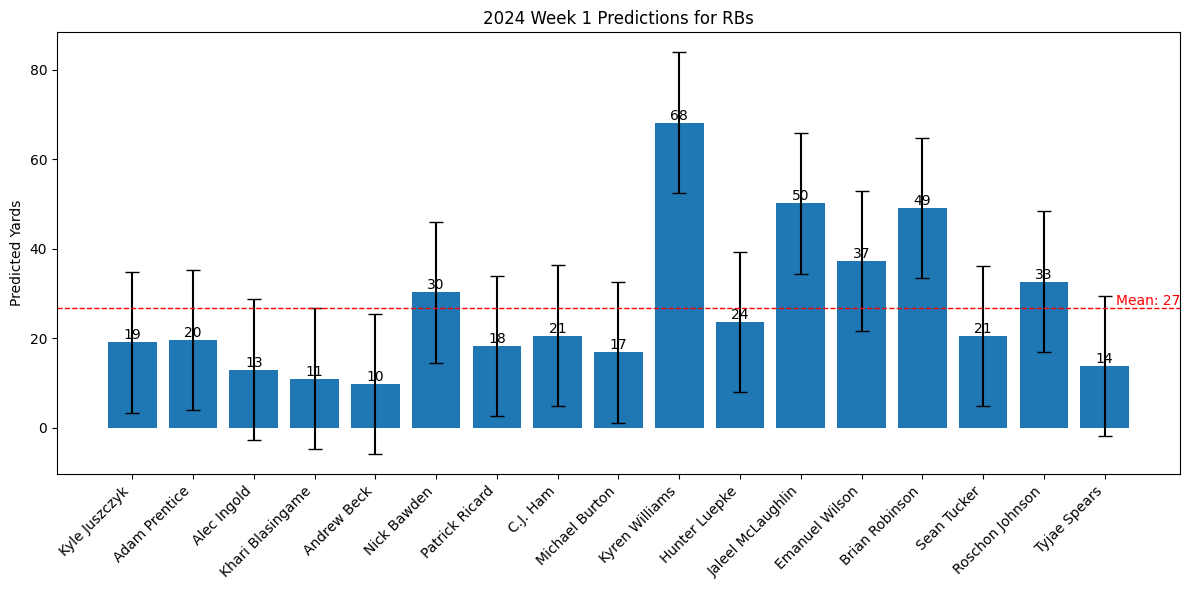

1/1 [==============================] - 0s 23ms/step
2024 Week 1 Prediction for Adam Thielen:
Team: CAR
Position: WR
Predicted receiving yards: 42.63
Error: No 2023 stats found for 'Thayer Thomas'.
Error: No 2023 stats found for 'Malik Knowles'.
Error: No 2023 stats found for 'Cephus Johnson III'.
Error: No 2023 stats found for 'Matt Landers'.
1/1 [==============================] - 0s 23ms/step
2024 Week 1 Prediction for Jake Bobo:
Team: SEA
Position: WR
Predicted receiving yards: 25.97
Error: No 2023 stats found for 'John Stephens Jr.'.
Error: No 2023 stats found for 'Jalen Moreno-Cropper'.
Error: No 2023 stats found for 'David Durden'.
Error: No 2023 stats found for 'Jared Wayne'.
Error: No 2023 stats found for 'Daniel Arias'.
Error: No 2023 stats found for 'Bryan Thompson'.
Error: No 2023 stats found for 'Tyrell Shavers'.
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Elijah Cooks:
Team: JAX
Position: WR
Predicted receiving yards: 25.34
Error: No 2023 

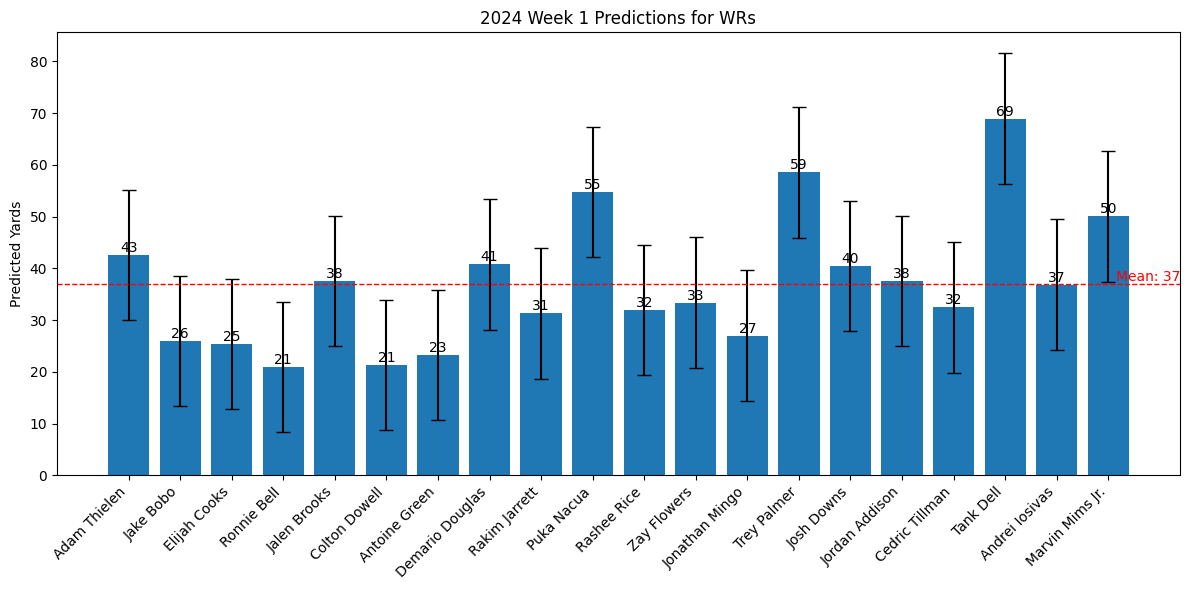

1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Zach Ertz:
Team: WAS
Position: TE
Predicted receiving yards: 26.94
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Will Mallory:
Team: IND
Position: TE
Predicted receiving yards: 24.48
Error: No 2023 stats found for 'Zack Kuntz'.
Error: No 2023 stats found for 'Travis Vokolek'.
Error: No 2023 stats found for 'Henry Pearson'.
Error: No 2023 stats found for 'Brady Russell'.
Error: No 2023 stats found for 'E.J. Jenkins'.
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Luke Schoonmaker:
Team: DAL
Position: TE
Predicted receiving yards: 19.46
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Darnell Washington:
Team: PIT
Position: TE
Predicted receiving yards: 15.76
Error: No 2023 stats found for 'Cameron Latu'.
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Josh Whyle:
Team: TEN
Position: TE

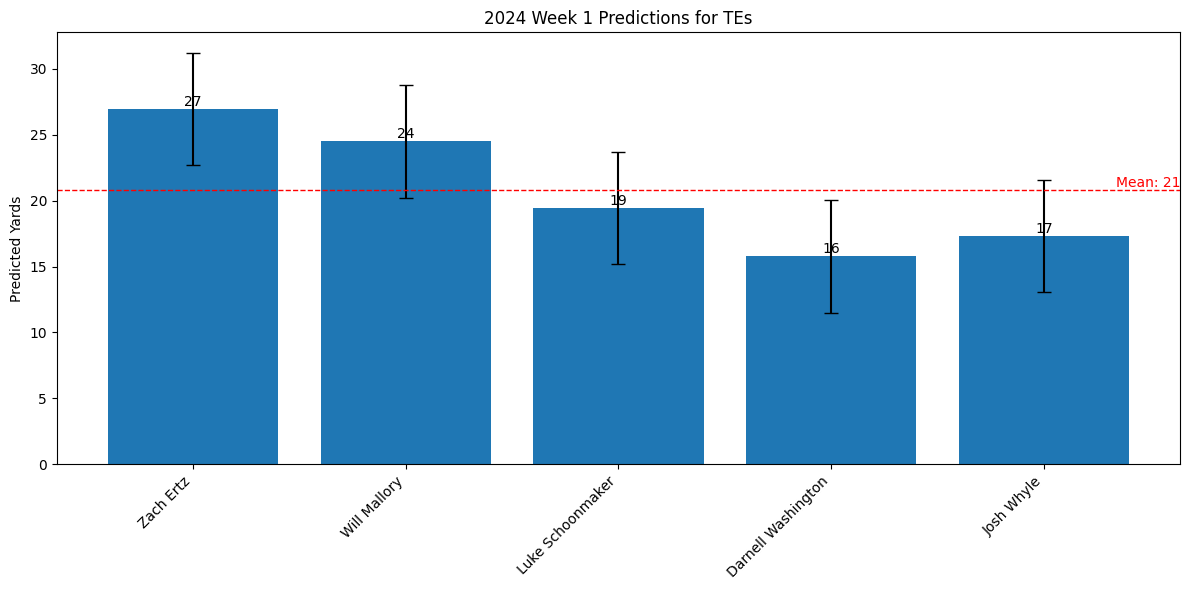

In [3]:
import matplotlib.pyplot as plt
from scipy import stats

def get_multiple_predictions(position, num_players):
    predictions = []
    players = latest_rosters[latest_rosters['position'] == position].sort_values('depth_chart_position')
    
    for _, player in players.head(num_players).iterrows():
        pred = predict_2024_week1(player['player_name'])
        if pred:  # Check if prediction was successful
            if position == 'QB':
                predictions.append((player['player_name'], pred['passing_yards']))
            elif position == 'RB':
                predictions.append((player['player_name'], pred['rushing_yards']))
            elif position in ['WR', 'TE']:
                predictions.append((player['player_name'], pred['receiving_yards']))
    
    return predictions

def plot_predictions_with_std(position, num_players):
    predictions = get_multiple_predictions(position, num_players)
    
    if not predictions:
        print(f"No valid predictions for {position}")
        return
    
    names, values = zip(*predictions)
    
    # Calculate mean and standard deviation
    mean = np.mean(values)
    std = np.std(values)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(names, values, yerr=std, capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Predicted Yards')
    ax.set_title(f'2024 Week 1 Predictions for {position}s')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom')
    
    # Add a horizontal line for the mean
    ax.axhline(mean, color='red', linestyle='dashed', linewidth=1)
    ax.text(ax.get_xlim()[1], mean, f'Mean: {mean:.0f}', 
            horizontalalignment='right', verticalalignment='bottom', color='red')
    
    plt.show()

# Example usage
plot_predictions_with_std('QB', 12)
plot_predictions_with_std('RB', 24)
plot_predictions_with_std('WR', 36)
plot_predictions_with_std('TE', 12)

Error: No 2023 stats found for 'Aaron Rodgers'.
Error: No 2023 stats found for 'Matt Ryan'.
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Joe Flacco:
Team: IND
Position: QB
Predicted passing yards: 236.45
Predicted rushing yards: 8.64
Error: No 2023 stats found for 'Josh Johnson'.
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Matthew Stafford:
Team: LA
Position: QB
Predicted passing yards: 285.54
Predicted rushing yards: 5.33
1/1 [==============================] - 0s 21ms/step
2024 Week 1 Prediction for Andy Dalton:
Team: CAR
Position: QB
Predicted passing yards: 218.53
Predicted rushing yards: 19.27
1/1 [==============================] - 0s 20ms/step
2024 Week 1 Prediction for Tyrod Taylor:
Team: NYJ
Position: QB
Predicted passing yards: 203.25
Predicted rushing yards: 9.66
1/1 [==============================] - 0s 22ms/step
2024 Week 1 Prediction for Case Keenum:
Team: HOU
Position: QB
Predicted passing yards: 268.02
P

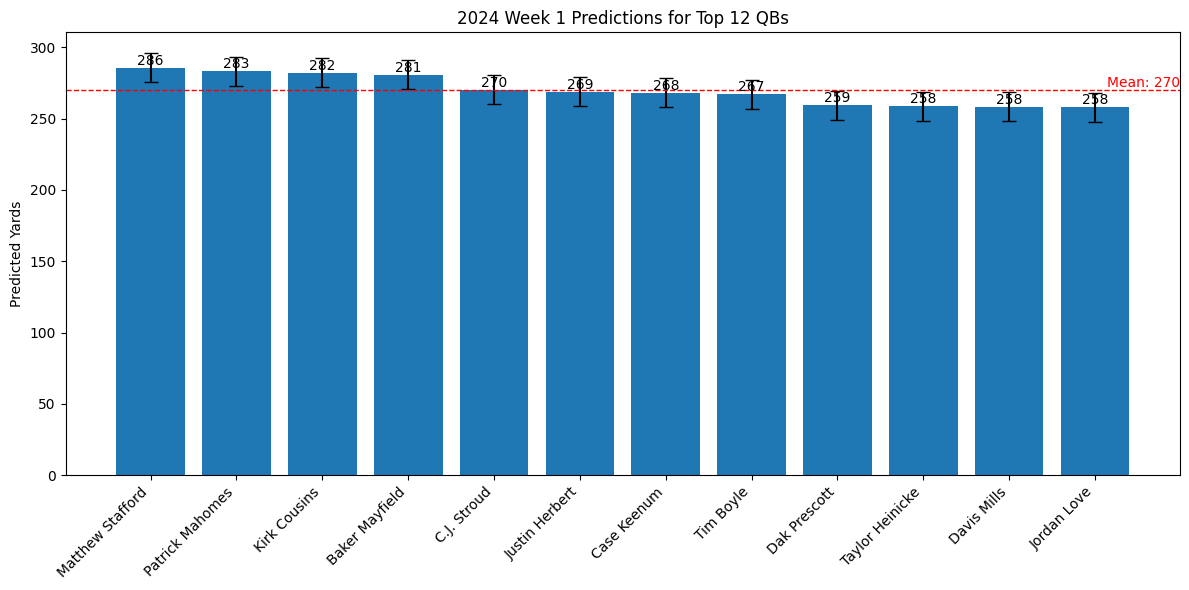

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def get_all_predictions(position):
    predictions = []
    players = latest_rosters[latest_rosters['position'] == position]
    
    for _, player in players.iterrows():
        pred = predict_2024_week1(player['player_name'])
        if pred:  # Check if prediction was successful
            if position == 'QB':
                predictions.append((player['player_name'], pred['passing_yards']))
            elif position == 'RB':
                predictions.append((player['player_name'], pred['rushing_yards']))
            elif position in ['WR', 'TE']:
                predictions.append((player['player_name'], pred['receiving_yards']))
    
    # Sort predictions in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions

def plot_top_predictions(position, top_n):
    all_predictions = get_all_predictions(position)
    
    if not all_predictions:
        print(f"No valid predictions for {position}")
        return
    
    # Take only the top_n predictions
    top_predictions = all_predictions[:top_n]
    names, values = zip(*top_predictions)
    
    # Calculate mean and standard deviation of the top_n predictions
    mean = np.mean(values)
    std = np.std(values)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(names, values, yerr=std, capsize=5)
    
    # Customize the plot
    ax.set_ylabel('Predicted Yards')
    ax.set_title(f'2024 Week 1 Predictions for Top {top_n} {position}s')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom')
    
    # Add a horizontal line for the mean
    ax.axhline(mean, color='red', linestyle='dashed', linewidth=1)
    ax.text(ax.get_xlim()[1], mean, f'Mean: {mean:.0f}', 
            horizontalalignment='right', verticalalignment='bottom', color='red')
    
    plt.show()

# Example usage
plot_top_predictions('QB', 12)